# Additional examples
Author: Audrey Olivier, 03-10-2019

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from UQpy.Inference import *
from UQpy.RunModel import RunModel # required to run the quadratic model
from sklearn.neighbors import KernelDensity # for the plots
from statsmodels.nonparametric.kde import KDEUnivariate

## Examples where the model takes in some fixed parameters

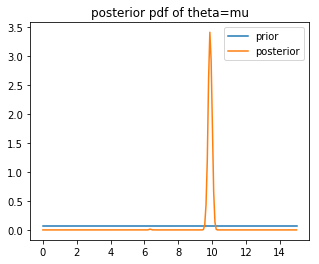

In [2]:
np.random.seed(100)
mu, sigma = 10, 1 # true mean and standard deviation
data_1 = np.random.normal(mu, sigma, 100)
np.random.seed()

# create an instance of class Model
candidate_model = Model(model_type = 'pdf', model_name='normal', n_params=1,
                        prior_name = ['uniform'], 
                        prior_params = [[0, 15]], fixed_params=[1])

# Learn the unknown parameters using MCMC
bayes_estimator = BayesParameterEstimation(data=data_1, sampling_method = 'MCMC', nsamples=500, 
                                           pdf_proposal = 'Normal', pdf_proposal_scale=[1], 
                                           model=candidate_model, 
                                           algorithm = 'MH', jump=10, nburn=10, 
                                           seed=np.array([1.0]))

fig, ax = plt.subplots(1,1, figsize=(5,4))
s = bayes_estimator.samples
domain = np.linspace(0, 15, 200)[:, np.newaxis]
bandwidth = 1.06*np.std(s[:,0])*s[:,0].shape[0]**(-1/5)
kde = KernelDensity(bandwidth=bandwidth).fit(s[:,0].reshape((-1,1)))
log_dens = kde.score_samples(domain)
ax.plot(domain, Distribution('uniform').pdf(domain, [0,15]), label='prior')
ax.plot(domain, np.exp(log_dens), label='posterior')
ax.set_title('posterior pdf of theta=mu')
ax.legend()

plt.show()

(1, 2)
[1.42768128e-01 4.57001867e-01 1.31741299e+00 1.81430336e+00
 4.74040176e+00 4.43796206e+00 7.09986168e+00 7.21965030e+00
 9.98741263e+00 1.45466254e+01 1.53748922e+01 1.63808571e+01
 1.89229644e+01 2.02123175e+01 2.34411258e+01 2.69890493e+01
 3.18818455e+01 3.33752519e+01 3.77408777e+01 4.32968991e+01
 4.57619170e+01 4.86937583e+01 5.30572470e+01 5.64689004e+01
 6.26147391e+01 6.58771805e+01 7.13631225e+01 7.80444038e+01
 8.36583603e+01 8.79296871e+01 9.24703145e+01 9.88492098e+01
 1.05387849e+02 1.10736487e+02 1.16941450e+02 1.24627036e+02
 1.29677225e+02 1.37885204e+02 1.43438185e+02 1.50968750e+02
 1.58300427e+02 1.65743843e+02 1.72220981e+02 1.82390146e+02
 1.88701329e+02 1.97414385e+02 2.02312415e+02 2.11829532e+02
 2.20610817e+02 2.31251011e+02]


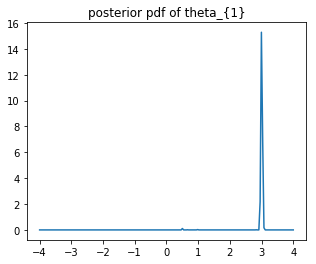

In [3]:
# Generate data from a quadratic function
from scipy.stats import multivariate_normal

param_true = np.array([3.0, 2.0]).reshape(1, -1)
error_covariance = np.eye(50)

print(param_true.shape)
z = RunModel(samples=param_true, model_script='pfn_models.py', model_object_name = 'model_quadratic', 
             var_names = ['theta_0', 'theta_1'])
data = z.qoi_list[0].reshape((-1,))+multivariate_normal.rvs(mean=None, cov=error_covariance, size=1)
print(data)

candidate_model = Model(n_params=1, model_type='python', 
                        model_script='pfn_models.py', model_object_name = 'model_quadratic',
                        error_covariance=error_covariance, fixed_params=[2.0])

bayes_estimator = BayesParameterEstimation(data=data, model=candidate_model, 
                                           sampling_method = 'MCMC', nsamples=500,
                                           algorithm = 'MH', jump=10, nburn=0, 
                                           pdf_proposal = 'Normal',
                                           pdf_proposal_scale = [0.1], seed = [0.5])

s = bayes_estimator.samples
fig, ax = plt.subplots(1,1, figsize=(5,4))

domain = np.linspace(-4, 4, 200)[:, np.newaxis]
kde = KDEUnivariate(s[:,0])
kde.fit(kernel='gau', bw='normal_reference', fft=False, weights=None)
pdf_ = []
for d in domain:
    pdf_.append(kde.evaluate(d))
ax.plot(domain, pdf_, label='posterior')
ax.set_title('posterior pdf of theta_{1}')
plt.show()

## Examples where the noise covariance is learnt along with the model parameters

In [4]:
# Generate data from a quadratic function
from scipy.stats import multivariate_normal

param_true = np.array([1.0, 2.0]).reshape(1, -1)
error_covariance = np.eye(50)

print(param_true.shape)
z = RunModel(samples=param_true, model_script='pfn_models.py', model_object_name = 'model_quadratic', 
             var_names = ['theta_0', 'theta_1'])
data = z.qoi_list[0].reshape((-1,))+multivariate_normal.rvs(mean=None, cov=error_covariance, size=1)
print(data)

(1, 2)
[ -0.90989949   2.43597232   2.62716847   3.25561743   3.32438556
   1.92031619   3.52615814   5.16566097   6.03551343   8.60543354
  11.06778711  12.12949039  13.23577334  17.52670752  16.19921846
  22.17270722  23.6456889   26.05423939  30.38964115  33.16961775
  35.81236556  41.64593752  44.73165409  48.22566473  51.23821191
  56.84691018  60.7598185   66.60431289  71.17267867  74.55557297
  80.01276546  85.26914058  91.98317676  99.61006279 103.32685561
 107.83074267 115.91732059 121.45318012 128.80834308 134.58066863
 141.19469029 150.33702273 155.84723388 163.84020838 170.43393524
 178.05632819 184.27030476 191.39087027 204.16522819 210.08304785]


In [5]:
model = Model(n_params=2, model_type='python', 
              model_script='pfn_models.py', model_object_name = 'model_quadratic',
              error_adapt=True, prior_error_name='lognormal', 
              prior_error_params=[1, 0, 1])

In [6]:
be = BayesParameterEstimation(data=data, model=model, sampling_method = 'MCMC', 
                              nsamples=2000,
                              algorithm = 'MH', jump=20, nburn=100, pdf_proposal = 'Normal',
                              pdf_proposal_scale = [0.1, 0.05, 0.025])

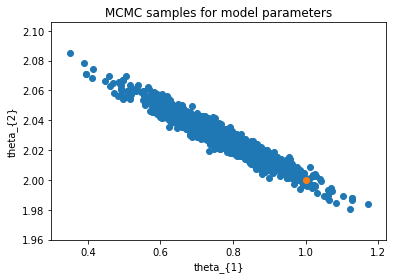

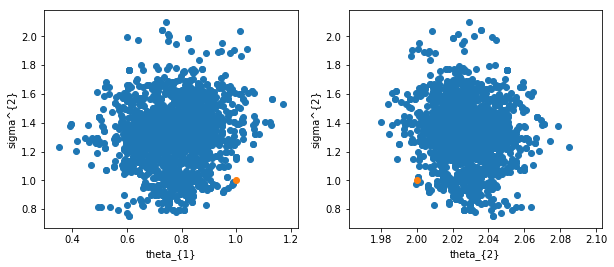

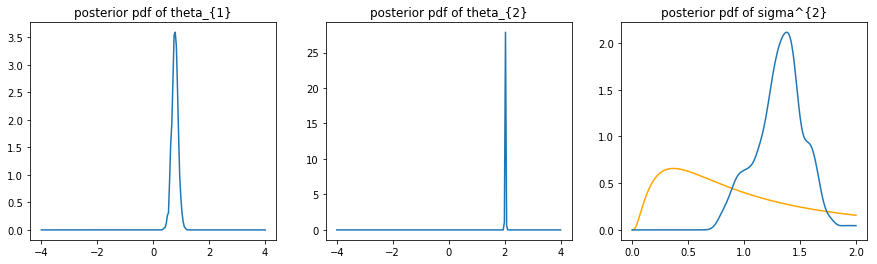

In [7]:
s = be.samples
plt.scatter(s[:,0],s[:,1])
plt.scatter(1.0, 2.0, label='true value')
plt.title('MCMC samples for model parameters')
plt.xlabel('theta_{1}')
plt.ylabel('theta_{2}')
plt.show()

fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].scatter(s[:,0],s[:,2])
ax[0].scatter(1.0, 1.0, label='true value')
ax[0].set_xlabel('theta_{1}')
ax[0].set_ylabel('sigma^{2}')
ax[1].scatter(s[:,1],s[:,2])
ax[1].scatter(2.0, 1.0, label='true value')
ax[1].set_xlabel('theta_{2}')
ax[1].set_ylabel('sigma^{2}')

plt.show()

fig, ax = plt.subplots(1,3, figsize=(15,4))

domain = np.linspace(-4, 4, 200)[:, np.newaxis]
kde = KDEUnivariate(s[:,0])
kde.fit(kernel='gau', bw='normal_reference', fft=False, weights=None)
pdf_ = []
for d in domain:
    pdf_.append(kde.evaluate(d))
ax[0].plot(domain, pdf_, label='posterior')
ax[0].set_title('posterior pdf of theta_{1}')

domain = np.linspace(-4, 4, 200)[:, np.newaxis]
kde = KDEUnivariate(s[:,1])
kde.fit(kernel='gau', bw='normal_reference', fft=False, weights=None)
pdf_ = []
for d in domain:
    pdf_.append(kde.evaluate(d))
ax[1].plot(domain, pdf_, label='posterior')
ax[1].set_title('posterior pdf of theta_{2}')

domain = np.linspace(0, 2, 200)[:, np.newaxis]
prior_sig2 = model.prior_error
pdf_ = prior_sig2.pdf(x=domain, params=model.prior_error_params)
ax[2].plot(domain, pdf_, label='prior', color='orange')
kde = KDEUnivariate(s[:,2])
kde.fit(kernel='gau', bw='normal_reference', fft=False, weights=None)
pdf_ = []
for d in domain:
    pdf_.append(kde.evaluate(d))
ax[2].plot(domain, pdf_, label='posterior')
ax[2].set_title('posterior pdf of sigma^{2}')

plt.show()